# Data Acquisition 


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor


In [39]:
df=pd.read_csv("train.csv")
df

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [40]:
df.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


# EDA

## Basic cleaning

In [ ]:
df.isnull().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [ ]:
df["Sex"].unique()
df["Sex"].value_counts()




female    375721
male      374279
Name: Sex, dtype: int64

In [ ]:
df.duplicated().sum()


0

Insights:
- 9 columns, 750 000 sample points in the training dataset
    -  8 numerical attributes => NEED SCALING 
    - 1 catogorical attribute: Sex with 2 unique values Male and Female => NEED ENCODER 
- No missing values, no duplicated

## Data understanding

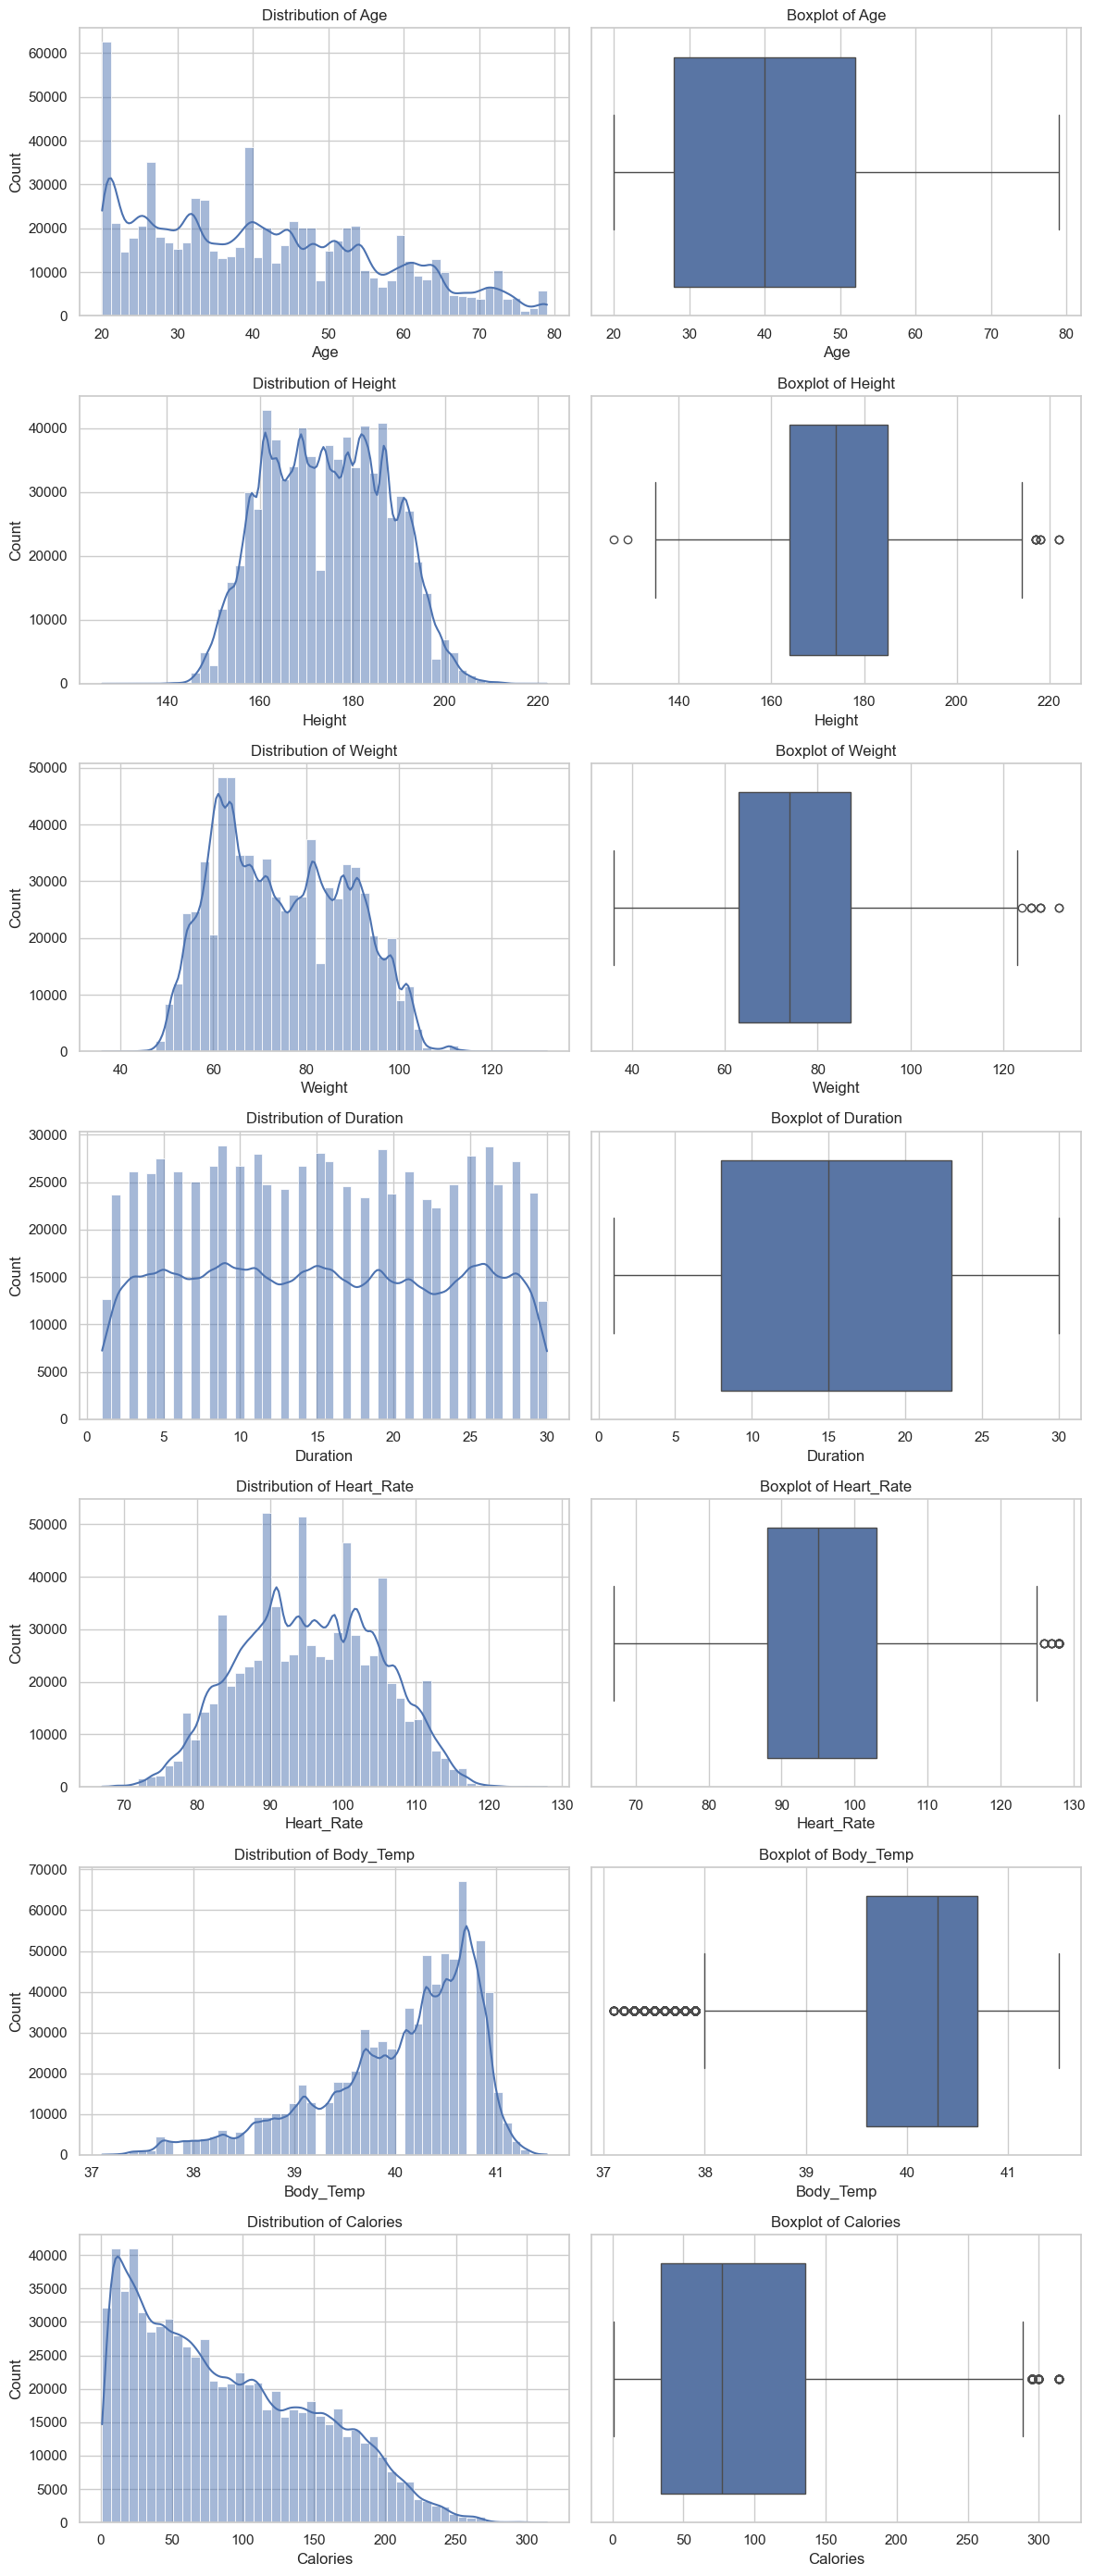

In [97]:
# Set plotting style
sns.set(style="whitegrid")

# Numerical columns except id
num_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# 1. Distribution Plots (Histograms + Boxplots)
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4*len(num_cols)))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {col}')
    
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [98]:
import numpy as np

def skewness_check(df, threshold=0):
    """
    Checks skewness of numerical columns in a DataFrame and classifies them
    as right-skewed, left-skewed, or symmetric based on a threshold.

    Returns a tuple of three lists of dictionaries:
    (right_skewed, left_skewed, symmetric), each list contains dicts with keys:
    'column', 'skewness', 'type'

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing numerical columns.
    threshold : float, default=0
        Absolute skewness threshold to classify skewed columns.
        Skewness within [-threshold, threshold] are symmetric.

    Returns
    -------
    tuple of lists of dicts:
        (right_skewed, left_skewed, symmetric)
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    skew_values = df[num_cols].skew()

    right_skewed_cols= []
    left_skewed_cols= []
    symmetric_cols= []

    for col, skew_val in skew_values.items():
        entry = {'column': col, 'skewness': skew_val}
        if skew_val > threshold:
            entry['type'] = 'right'
            right_skewed_cols.append(entry)
        elif skew_val < -threshold:
            entry['type'] = 'left'
            left_skewed_cols.append(entry)
        else:
            entry['type'] = 'symmetric'
            symmetric_cols.append(entry)
            
    return right_skewed_cols, left_skewed_cols, symmetric_cols


In [99]:
skewed_right_cols, skewed_left_cols, symmetric_cols = skewness_check(df, 0.3)
print(f"Lệch trái:", skewed_left_cols)
print(f"Lệch phải:",skewed_right_cols)

Lệch trái: [{'column': 'Body_Temp', 'skewness': -1.0223613156736593, 'type': 'left'}]
Lệch phải: [{'column': 'Age', 'skewness': 0.43639747566132264, 'type': 'right'}, {'column': 'Calories', 'skewness': 0.539196264522959, 'type': 'right'}]


Insights: 
Age: Asymmetric slightly to the right

Height: There are might some outliers on both side => need IQR

Weight: some higher outliers => may need IQR

Duration: quite balanced

Heart Rate: some higher values.

Body Temperature: slight left skew. 

Calories: Skewed right, with many low values and fewer high calorie burns.

In [100]:
import numpy as np

df_log_transformed = df.copy()

for col in skewed_right_cols.:
    
    df_log_transformed[col] = np.log1p(df_log_transformed[col])


SyntaxError: invalid syntax (1685620271.py, line 5)

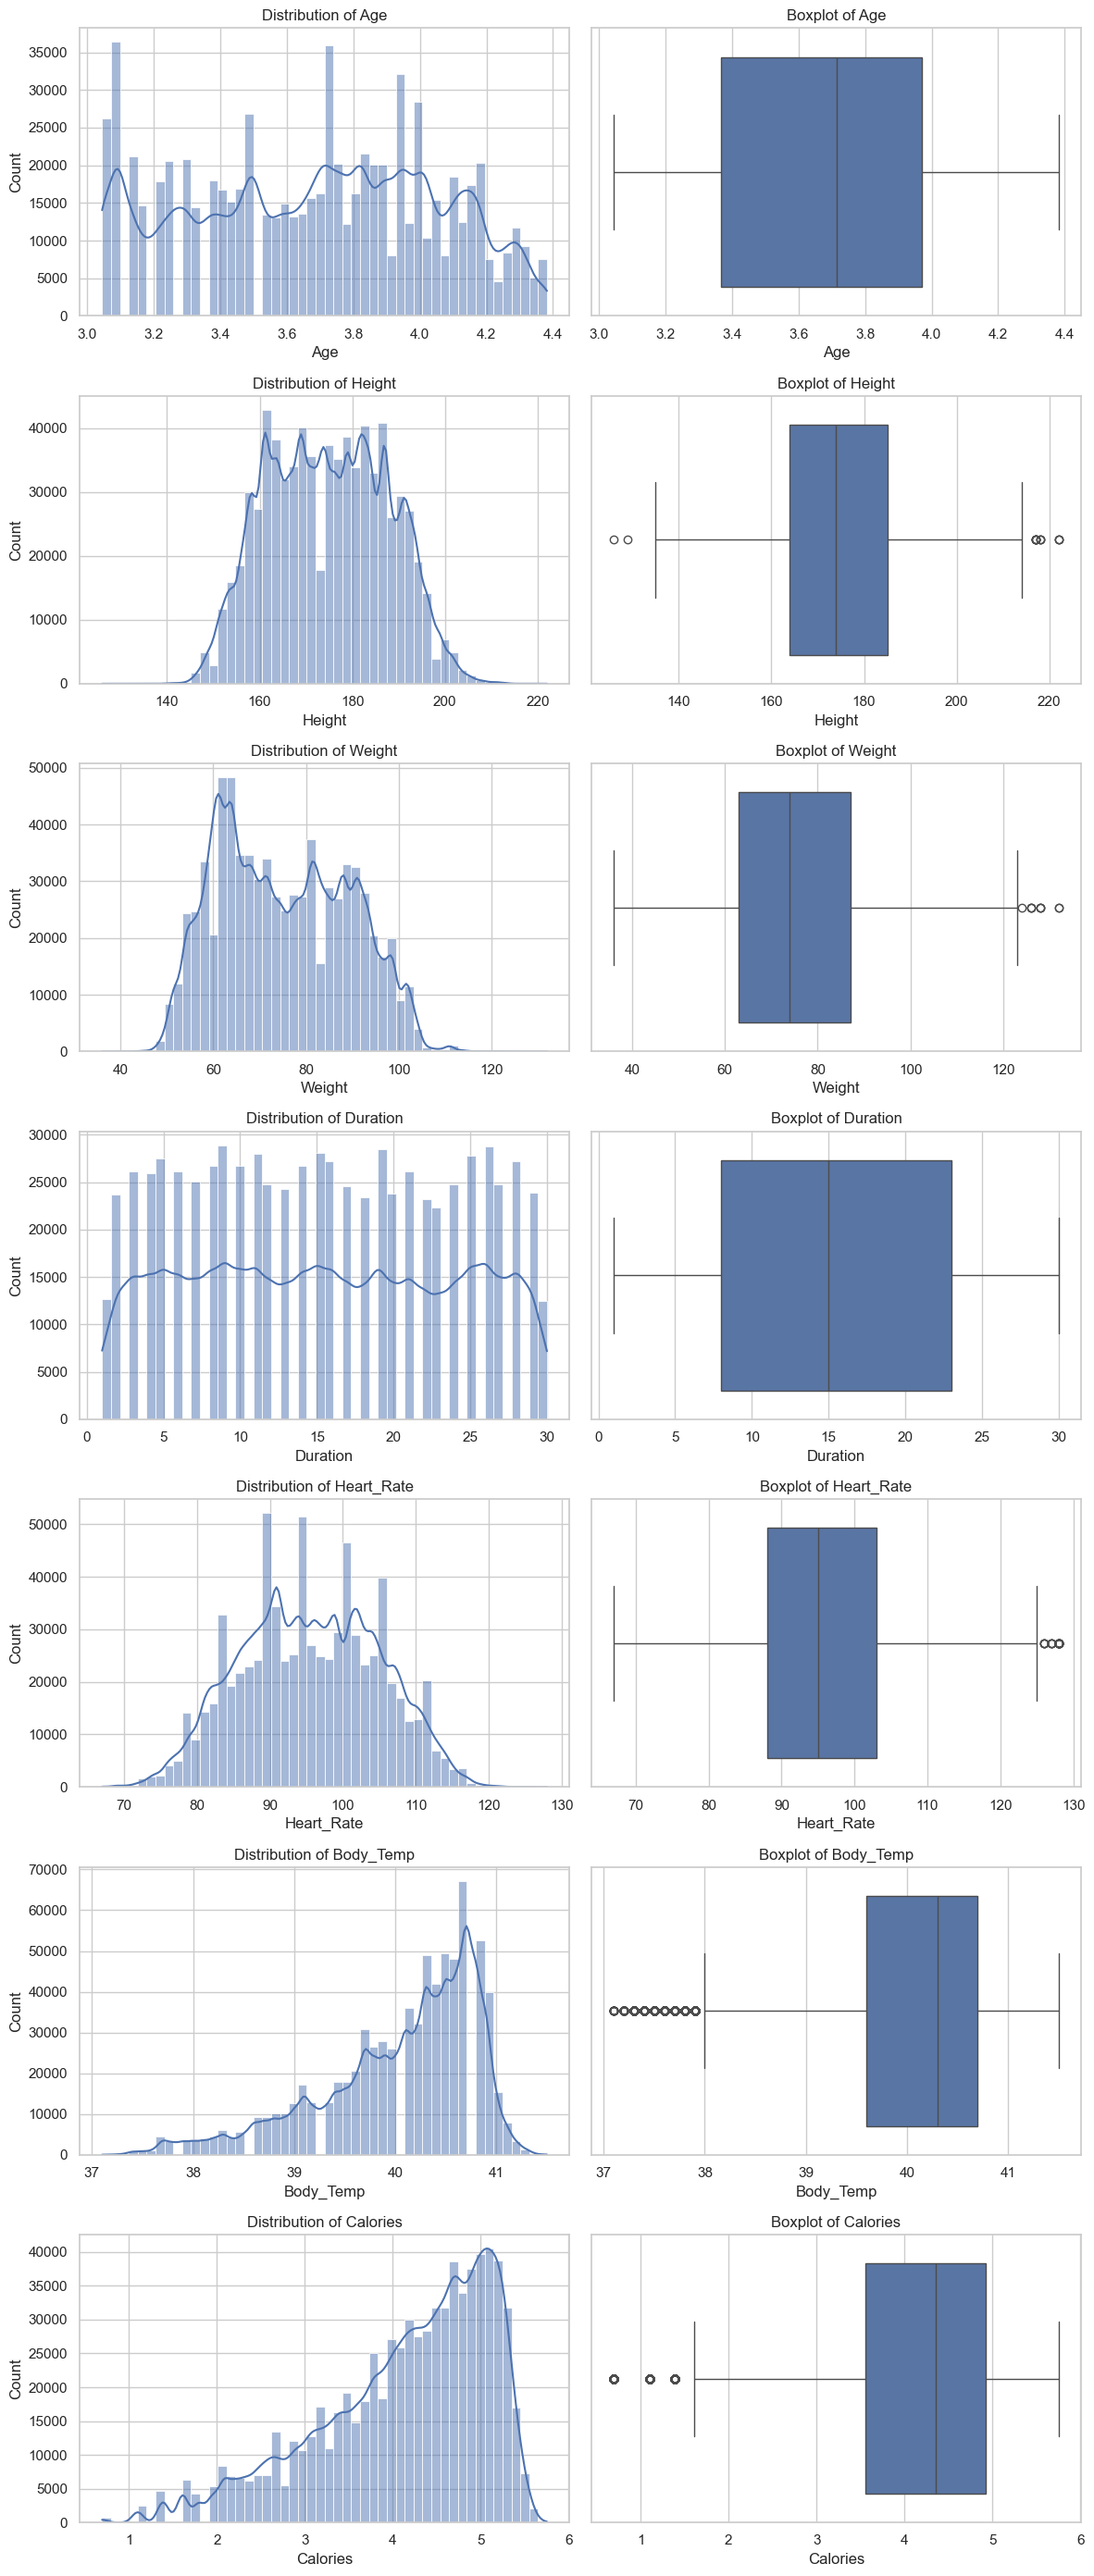

In [ ]:

# Giả sử num_cols là danh sách các cột số bạn muốn kiểm tra
# num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    # Plot histogram + KDE
    sns.histplot(df_log_transformed[col], bins=50, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {col}')
    
    # Plot boxplot
    sns.boxplot(x=df_log_transformed[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


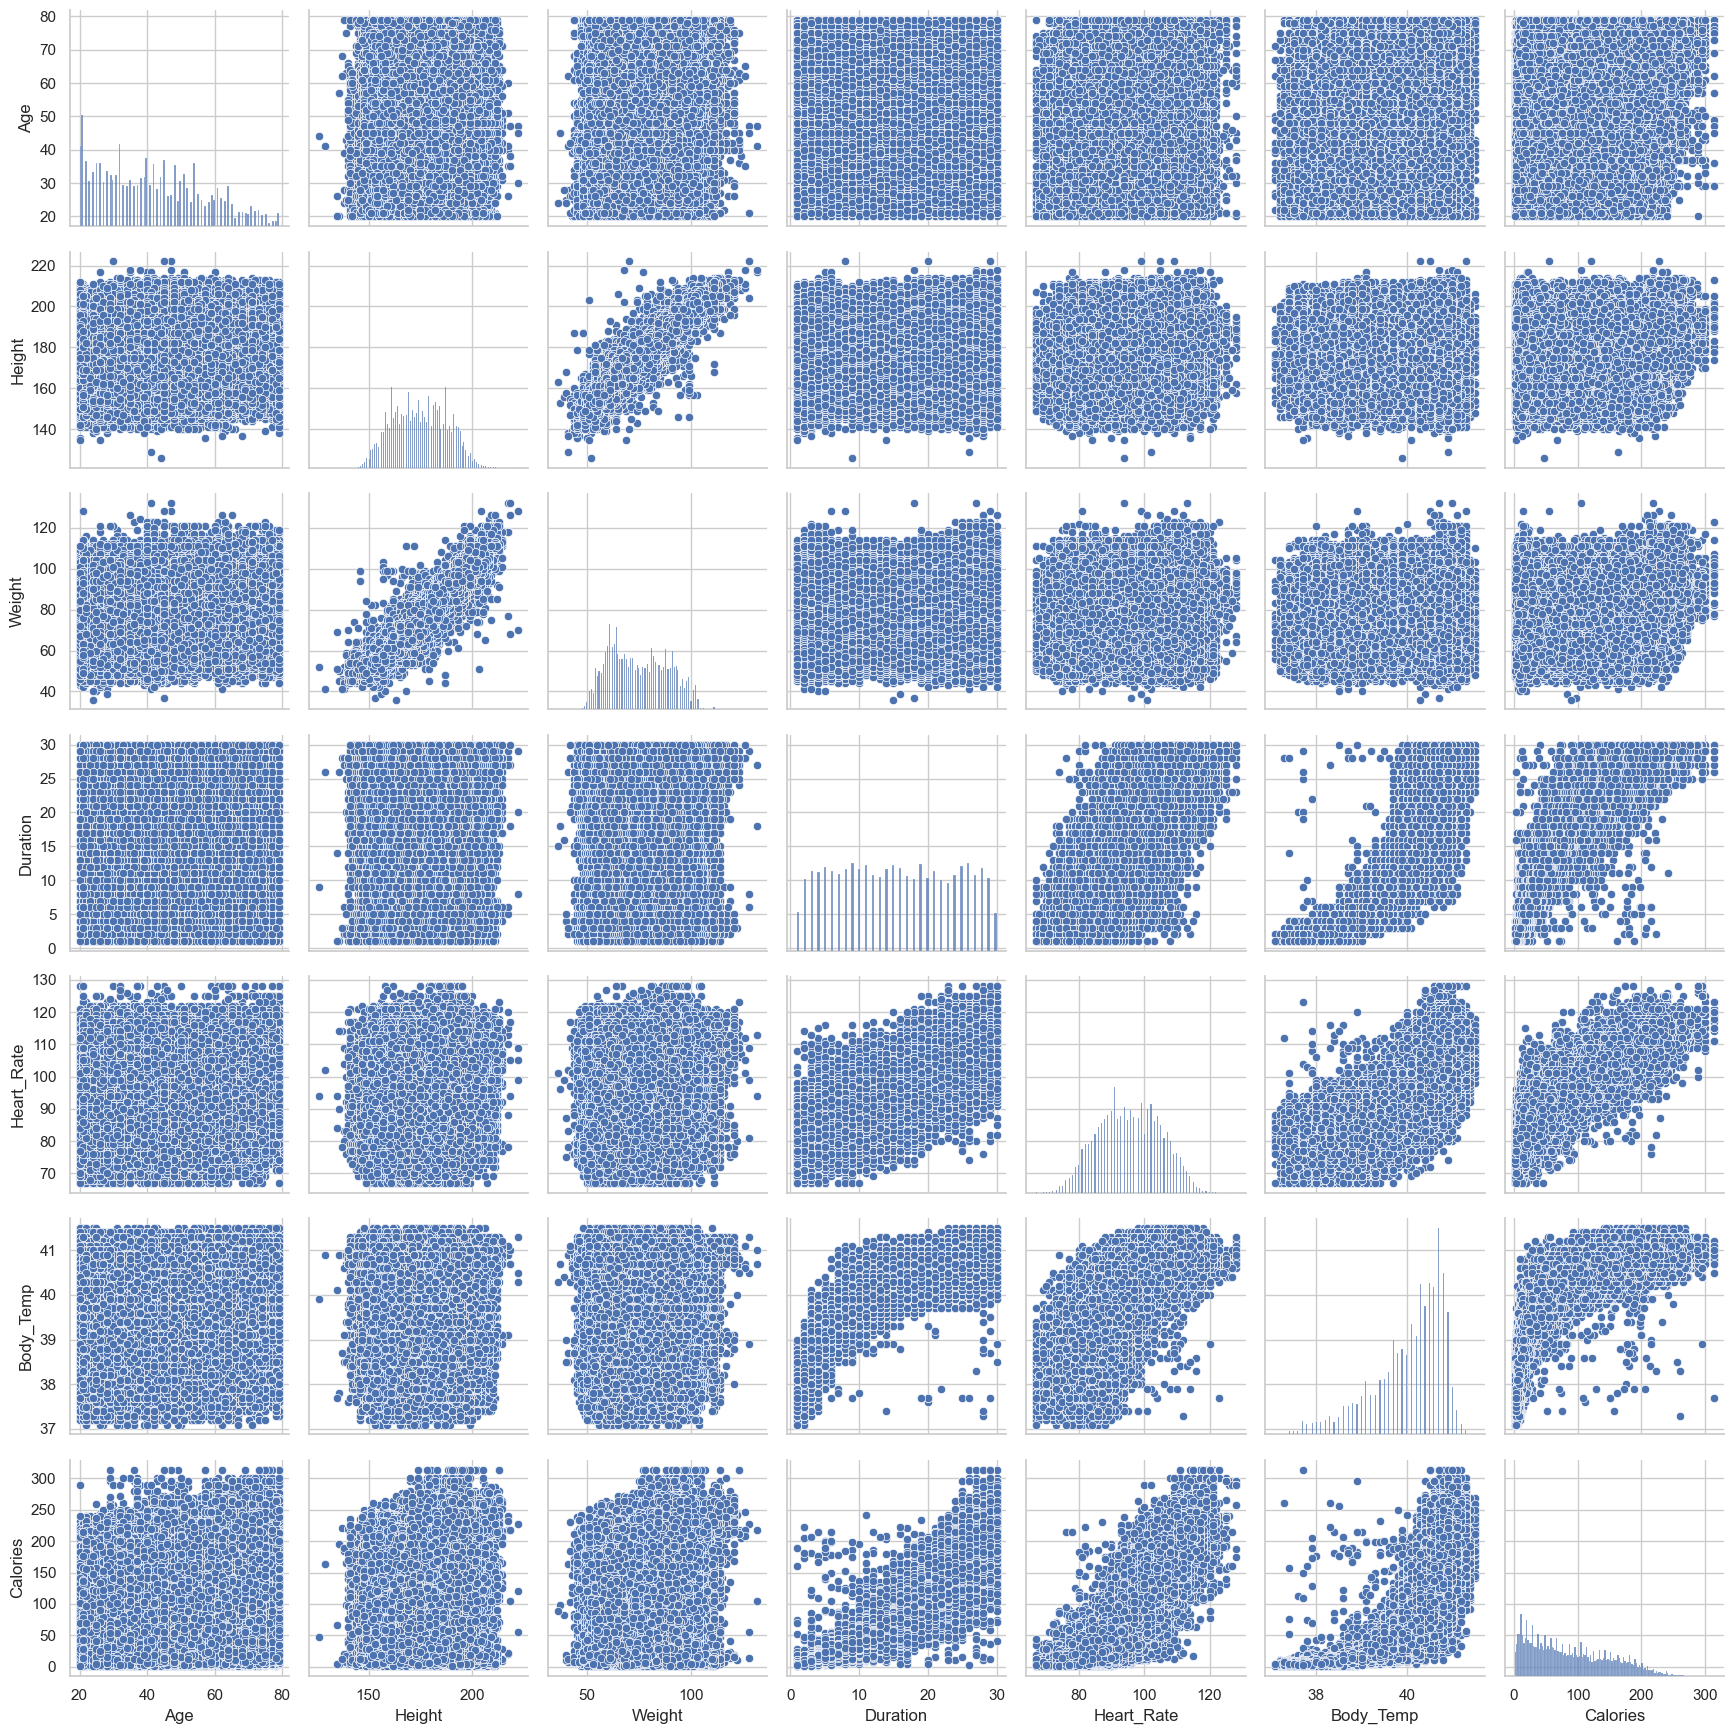

In [ ]:
sns.pairplot(df.drop(columns="id"))
plt.tight_layout()
plt.show()

In [ ]:

# Lấy danh sách các cột số
num_cols = df_log_transformed.select_dtypes(include=[np.number]).columns.tolist()

# Tính skewness từng cột (trả về Series)
skew_values = df_log_transformed[num_cols].skew()

# In kết quả và đánh giá từng cột
for col, skew_val in skew_values.items():
    print(f"Skewness của cột {col}: {skew_val:.4f}")
    if skew_val > 0:
        print(f"  => Dữ liệu {col} bị lệch phải (right skewed).")
    elif skew_val < 0:
        print(f"  => Dữ liệu {col} bị lệch trái (left skewed).")
    else:
        print(f"  => Dữ liệu {col} gần như đối xứng.")


Skewness của cột id: -0.0000
  => Dữ liệu id bị lệch trái (left skewed).
Skewness của cột Age: -0.0915
  => Dữ liệu Age bị lệch trái (left skewed).
Skewness của cột Height: 0.0518
  => Dữ liệu Height bị lệch phải (right skewed).
Skewness của cột Weight: 0.2112
  => Dữ liệu Weight bị lệch phải (right skewed).
Skewness của cột Duration: 0.0263
  => Dữ liệu Duration bị lệch phải (right skewed).
Skewness của cột Heart_Rate: -0.0057
  => Dữ liệu Heart_Rate bị lệch trái (left skewed).
Skewness của cột Body_Temp: -1.0224
  => Dữ liệu Body_Temp bị lệch trái (left skewed).
Skewness của cột Calories: -0.8570
  => Dữ liệu Calories bị lệch trái (left skewed).


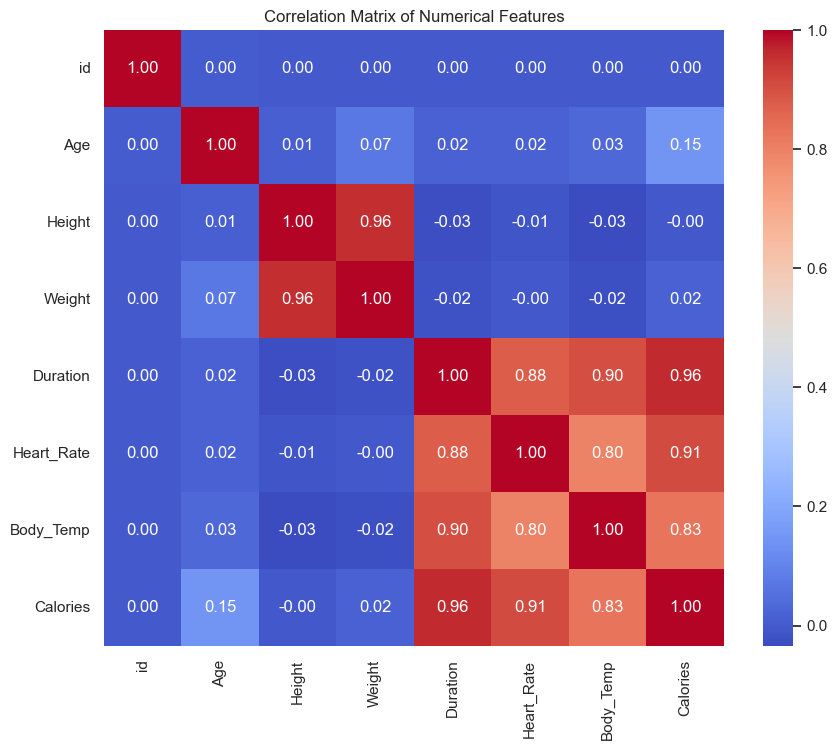

In [ ]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

1. Strong Positive Correlations:

- Duration and Calories (0.96): The length of exercise strongly influences calories burned. Longer durations lead to higher calorie expenditure.

- Heart Rate and Calories (0.91): A higher heart rate during activity is closely associated with increased calorie burn.

- Body Temperature and Calories (0.83): Elevated body temperature during exercise correlates well with calories burned, likely reflecting physical exertion.

- Duration, Heart Rate, and Body Temperature are all strongly interrelated (0.80-0.90 range), showing these physiological measures rise together during exercise.

2. Moderate to Weak Correlations:

- Age and Calories (0.15): Slight positive correlation suggesting older individuals may burn slightly more calories, but it’s weak.

- Height and Weight (0.96): Expected strong positive correlation—taller individuals tend to weigh more.

- Weight and Calories (0.02): Very weak correlation, indicating weight alone doesn't strongly affect calories burned in this dataset.

3. Negligible or Negative Correlations:

- Negative or near-zero correlations between height, weight with duration, heart rate, and body temp indicate these physical attributes don't strongly influence exercise intensity measures or calorie burn here.

In [ ]:
# Correlation significance: Use Pearson correlation test between pairs of numerical variables to check if correlations are statistically significant (p-value < 0.05).
# # Get all numerical columns except id
num_cols_full = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# Prepare list to collect all pair results
all_results = []

# Run Pearson correlation tests for all unique pairs (including self-pairs)
for i, var1 in enumerate(num_cols_full):
    for j, var2 in enumerate(num_cols_full):
        if j > i:  # to avoid duplicate pairs and self-correlation
            corr_coef, p_value = pearsonr(df[var1], df[var2])
            all_results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Correlation Coefficient': corr_coef,
                'P-Value': p_value,
                'Significant (p < 0.05)': p_value < 0.05
            })

# Convert to DataFrame for better visualization
all_corr_results_df = pd.DataFrame(all_results)
all_corr_results_df


,Variable 1,Variable 2,Correlation Coefficient,P-Value,Significant (p < 0.05)
0,Age,Height,0.011975,3.352495e-25,True
1,Age,Weight,0.073690,0.000000e+00,True
2,Age,Duration,0.015656,6.946182e-42,True
3,Age,Heart_Rate,0.017037,2.819937e-49,True
4,Age,Body_Temp,0.030275,1.381671e-151,True
5,Age,Calories,0.145683,0.000000e+00,True
6,Height,Weight,0.957967,0.000000e+00,True
7,Height,Duration,-0.029936,2.958647e-148,True
8,Height,Heart_Rate,-0.013234,2.055171e-30,True
9,Height,Body_Temp,-0.034641,7.473604e-198,True


All tested correlations are statistically significant (p < 0.05).
Even small correlations like Weight vs Calories (0.016) are statistically significant due to large sample size, but the effect size is negligible.

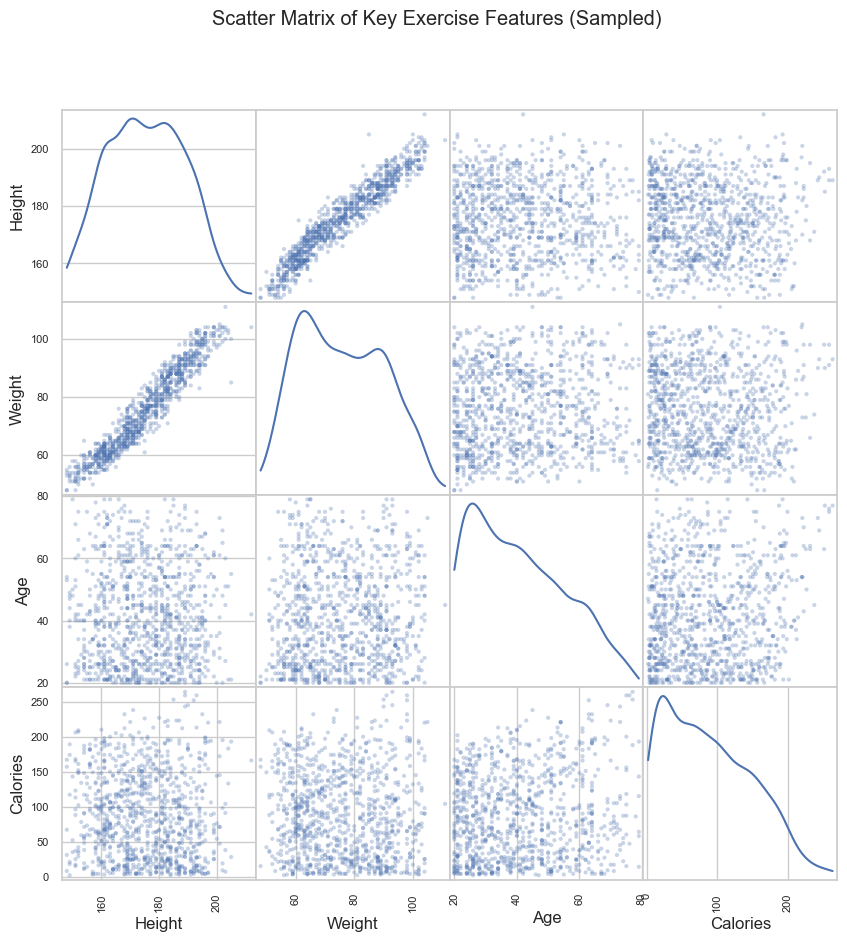

In [ ]:
attributes = ['Height', 'Weight', 'Age', 'Calories']

sample_df = df[attributes].sample(1000, random_state=42)

scatter_matrix(sample_df, figsize=(10, 10), diagonal='kde', alpha=0.3)
plt.suptitle("Scatter Matrix of Key Exercise Features (Sampled)")
plt.show()

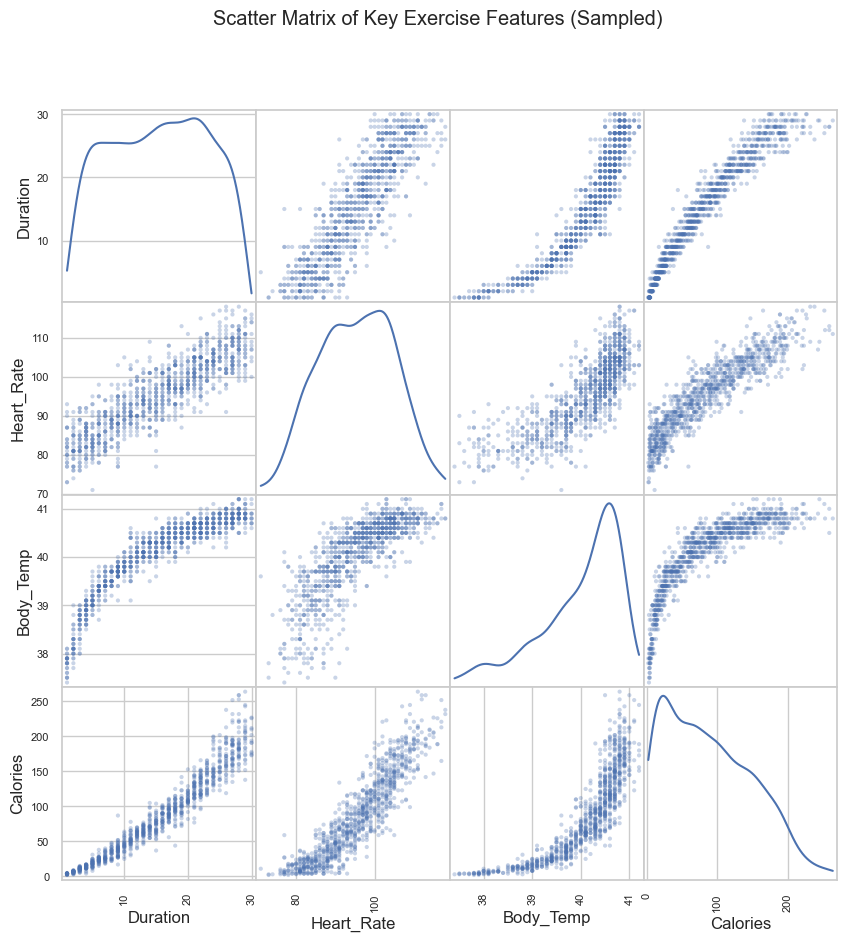

In [ ]:
attributes = ['Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

sample_df = df[attributes].sample(1000, random_state=42)

scatter_matrix(sample_df, figsize=(10, 10), diagonal='kde', alpha=0.3)
plt.suptitle("Scatter Matrix of Key Exercise Features (Sampled)")
plt.show()

## Data preparation to Modelling

In [ ]:
# Prepare features and target
y_column = "Calories"
X = df.drop(columns=[y_column])

# Drop 'id' column if present
if 'id' in X.columns:
    X = X.drop(columns=['id'])

y = df[y_column]

categorical_cols = ['Sex']  # categorical column to encode
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
if 'Sex' in numeric_cols:
    numeric_cols.remove('sex')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=42, verbose=0))
     ])

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model_pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = model_pipeline.predict(X_val)

# Evaluate
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
y_val_clipped = np.clip(y_val, a_min=0, a_max=None)
y_pred_clipped = np.clip(y_pred, a_min=0, a_max=None)
msle = mean_squared_log_error(y_val_clipped, y_pred_clipped)


print(f"Validation MSE: {mse:.4f}")
print(f"Validation R²: {r2:.4f}")
print(f"Validation MSLE: {msle:.4f}")

Validation MSE: 12.6440
Validation R²: 0.9967
Validation MSLE: 0.0038


In [ ]:
# Get all parameters of the pipeline (including nested)
params = model_pipeline.get_params()

# Print parameters sorted by key
for param_name in sorted(params):
    print(f"{param_name}: {params[param_name]}")


memory: None
preprocessor: ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Age', 'Height', 'Weight', 'Duration',
                                  'Heart_Rate', 'Body_Temp']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex'])])
preprocessor__cat: OneHotEncoder(handle_unknown='ignore')
preprocessor__cat__categories: auto
preprocessor__cat__drop: None
preprocessor__cat__dtype: <class 'numpy.float64'>
preprocessor__cat__feature_name_combiner: concat
preprocessor__cat__handle_unknown: ignore
preprocessor__cat__max_categories: None
preprocessor__cat__min_frequency: None
preprocessor__cat__sparse_output: True
preprocessor__force_int_remainder_cols: True
preprocessor__n_jobs: None
preprocessor__num: StandardScaler()
preprocessor__num__copy: True
preprocessor__num__with_mean: True
preprocessor__num__with_std: True
preprocessor__remainder: drop
preprocessor__sparse_threshold: 0.3

In [ ]:
# Lấy model hồi quy cuối cùng trong pipeline
regressor = model_pipeline.named_steps['regressor']

# Lấy hệ số (coefficients)
coefficients = regressor.coef_
intercept = regressor.intercept_

print("Hệ số (coefficients) của mô hình:", coefficients)
print(f"Intercept (free coefficient): {intercept:.4f}")

Hệ số (coefficients) của mô hình: [  8.07890174  -1.8817437    3.77374955  56.48217341  18.44445832
 -14.19354663   0.84400321  -0.84400321]
Intercept (free coefficient): 88.2970


In [ ]:
# Lấy bước tiền xử lý trong pipeline
preprocessor = model_pipeline.named_steps['preprocessor']

# Lấy các cột numeric và categorical
numeric_cols = preprocessor.transformers_[0][2]
categorical_cols = preprocessor.transformers_[1][2]

# Lấy tên các feature numeric (giữ nguyên)
numeric_features = list(numeric_cols)

# Lấy tên các feature categorical sau one-hot encoding
cat_transformer = preprocessor.transformers_[1][1]  # OneHotEncoder instance
cat_features = cat_transformer.get_feature_names_out(categorical_cols)

# Tổng hợp tên đặc trưng cuối cùng
feature_names = np.concatenate([numeric_features, cat_features])

# Lấy hệ số từ mô hình hồi quy
coefficients = model_pipeline.named_steps['regressor'].coef_

# In tên đặc trưng và hệ số tương ứng
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")


Age: 8.0789
Height: -1.8817
Weight: 3.7737
Duration: 56.4822
Heart_Rate: 18.4445
Body_Temp: -14.1935
Sex_female: 0.8440
Sex_male: -0.8440


# Optimization


# References